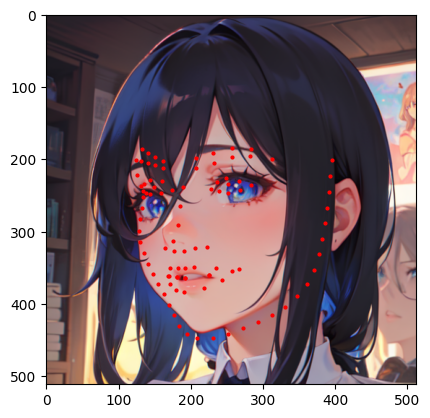

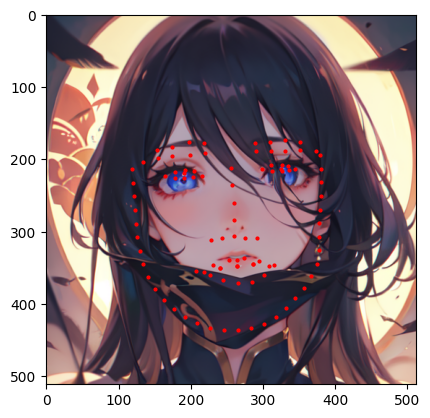

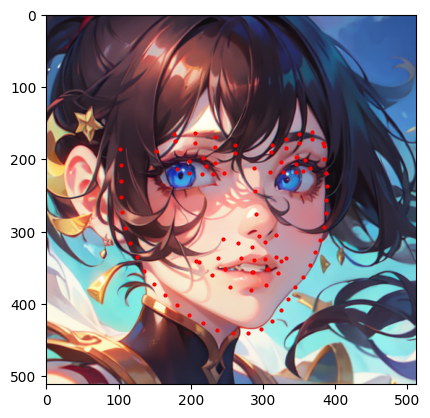

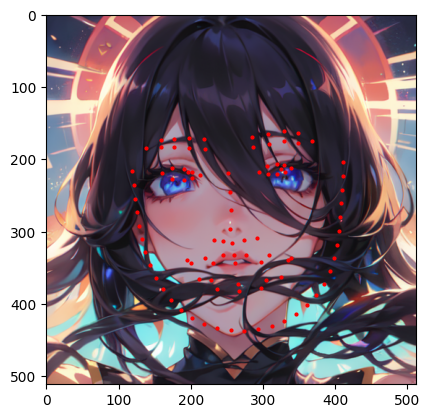

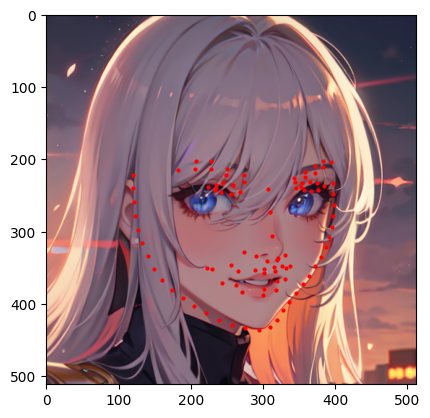

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import webuiapi
import csv


# WFLWのアノテーションデータの読み込み
annotation_data_path = "/root/dataset/WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt"
WFLW_images = "/root/dataset/WFLW/WFLW_images"
# prompts = [
#     "1girl,face,beautiful,masterpiece,anime,cute",
#     # "1girl,masterpiece,anime,cute,best quality, highly detailed,face,beautiful",
#     "1boy,face,beautiful,masterpiece,anime,cool,detailed,insanely detailed","nose",
#     # "1boy,face,beautiful,masterpiece,anime,cute,ultra detailed",
#     "1girl,face,beautiful,masterpiece,anime,cute,red eyes,insanely detailed,highly detailed,flat color",
#     "1girl,face,beautiful,masterpiece,anime,cute,red eyes,insanely detailed,highly detailed,line art",
#     # "1girl,face,beautiful,masterpiece,anime,cute,red eyes,insanely detailed,highly detailed,flat color,simple",
# ]
# negative_prompt = "lowres, (worst quality:1.5), (low quality:1.5), normal quality, text, watermark"



image_save_path = "/root/dataset/generated_images_dataset/image"
annotation_save_path = "/root/dataset/generated_images_dataset/annotations"

api = webuiapi.WebUIApi(host='10.8.76.222', port=7860) # control_image

with open(annotation_data_path) as f:
    anotation_data = f.readlines()
anotation_data_lists = []
for i in anotation_data:
    anotation_data_lists.append(i.split(" "))
    
# image_num = 1
for image_num in range(0,5):
    # 入力画像の加工-------------------------------------------------------------------------------------------
    image_name = anotation_data_lists[image_num][-1].replace("\n","")
    # print(image_name)
    image_path = WFLW_images + "/" + image_name
    bounding_box_data = tuple([int(bdbox) for bdbox in anotation_data_lists[image_num][-11:-7]])
    # fig, ax = plt.subplots(1)
    image = Image.open(image_path)
    # 顔画像のバウンディングボックスのサイズ
    face_width = bounding_box_data[2]-bounding_box_data[0]
    face_height = bounding_box_data[3]-bounding_box_data[1]
    # print(face_width)
    # print(face_height)
    #顔の中心座標
    face_center_x = float((bounding_box_data[2]+bounding_box_data[0]) / 2)
    face_center_y = float((bounding_box_data[3]+bounding_box_data[1]) / 2)
    # print("face_center",face_center_x,face_center_y)

    # クロップサイズの決定
    margin = float((face_width+face_height) / 2 * 0.2)
    half_long_side = max(face_width,face_height) / 2
    image_size = margin + half_long_side
    # print("image_size:",image_size)
    crop_size = (
        face_center_x-image_size,
        face_center_y-image_size,
        face_center_x+image_size,
        face_center_y+image_size
    )
    # print(crop_size)
    control_image = image.crop(crop_size)
    # ax.imshow(control_image)

    # ランドマーク座標の加工-------------------------------------------------------------------------------------------
    crop_keypoints_x = [float(keypoint) - crop_size[0] for keypoint in anotation_data_lists[image_num][0:196:2]]
    crop_keypoints_y = [float(keypoint) - crop_size[1] for keypoint in anotation_data_lists[image_num][1:196:2]]
    # print("bounding_box_data",bounding_box_data)
    x_np = np.array(crop_keypoints_x)
    y_np = np.array(crop_keypoints_y)
    
    # 生成画像のランドマーク用意
    genimage_keypoints_x = [float(keypoint_x * (512 / (image_size*2))) for keypoint_x in crop_keypoints_x]
    genimage_keypoints_y = [float(keypoint_y * (512 / (image_size*2))) for keypoint_y in crop_keypoints_y]
    x_np = np.array(genimage_keypoints_x)
    y_np = np.array(genimage_keypoints_y)
    # print(x_np[0:10])
    # print(y_np[0:10])
    
    # prompts = [
    #     "1girl, low ponytail, no wind, messy hair, best brown girl hair, outdoors, white shorts, amusement park,casualty, depth of field, best quality, aesthetic, detailed, best quality, anime screencap, aesthetic, volumetric lighting, created by Artgerm, photography, masterpiece, clean face, realistic, beautiful, view from below",
    #     "1girl,female, women,face, stone age technology, ice age, cosmic night sky, blue eyes",
    #     "asterpeace,best quality,highres,1girl,solo,blonde hair,maid,blue eyes,side ponytail,hair scrunchie,hair ornament,blue scrunchie,maid headdress,hair between eyes,long sleeves,bangs,black dress,sidelocks,maid apron,hands behind your back,indoors",
    #     "complex 3d render ultra detailed of a beautiful porcelain profile woman android face, cyborg, robotic parts, 150 mm, beautiful studio soft light, rim light, vibrant details, luxurious cyberpunk, lace, hyperrealistic, anatomical, facial muscles, cable electric wires, microchip, elegant, beautiful background, octane render, H. R. Giger style, 8k, best quality, masterpiece, illustration, an extremely delicate and beautiful, extremely detailed ,CG ,unity ,wallpaper, (realistic, photo-realistic:1.37),Amazing, finely detail, masterpiece,best quality,official art, extremely detailed CG unity 8k wallpaper, absurdres, incredibly absurdres"
    # ]
    prompts = [
        "hair, quality, eyes, best, winning, detailed, face,  Masterpiece, Award, Quality, solo, quality,1girl, masterpiece, anime,Anime,(perfect anime illustration)"
    ]
    negative_prompt = "young age, child, blur, poorly drawn face, disfigured, weak colors, extra fingers, (low quality, worst quality:1.3), deformed face"
    
    # イラスト生成
    unit1 = webuiapi.ControlNetUnit(
            input_image=control_image,
            module='openpose_faceonly',
            model='control_v11p_sd15_openpose [cab727d4]',
            weight=1.4
        )
    
    
    # fig, ax = plt.subplots(1)
    for num,prompt in enumerate(prompts):
        image_file_name = image_name.split("/")[1].replace(".jpg","")
        r = api.txt2img(
            prompt=prompt,
            negative_prompt=negative_prompt,
            width=512,
            height=512,
            steps=28,
            controlnet_units=[unit1]
        )       
        
        fig,ax = plt.subplots(1)
        ax.imshow(r.image)
        plt.plot(x_np, y_np, 'o',color='red',markersize=2)
        plt.show()
        # r.image.save(f"{image_save_path}/{image_file_name}_{num}.jpg")
        
        #アノテーションデータをcsvファイルに保存する
        # annotation_data_csv = [val for pair in zip(genimage_keypoints_x, genimage_keypoints_y) for val in pair]
        # annotation_data_csv.insert(0,f"{image_file_name}_{num}.jpg")
        
        # with open(f"{annotation_save_path}/annotations.csv","a") as f:
        #     writer = csv.writer(f)
        #     writer.writerow(annotation_data_csv)        
        

In [9]:
prompts = [
    "(Masterpiece, Award winning , Best Quality:1. 2), art by Shintaro Kago, solo, menhera, Yamikawa Punk, jirai kei, (jirai kei fashion:1. 1), detailed face, pink eyes, white Blouse, Frills, Skirts, Various accessories, (ear piercing), Japanese subculture, fashion, grunge, noise pop, Manic, punky style, (Akihabara:1. 1)\, Stockings, colorful, pink theme, (Dark circles:1. 2), 16k, UHD, HDR, (Masterpiece:1. 5), (best quality:1. 5),",
    "(masterpiece, award winning, high quality:1. 2), art by Adrian Smith, (psychedelic art), menhera girl, 1girl, solo, detailed face, grey eyes, pop culture, Manic, Post-Punk, hard core, nightclub, ((deep)), colorful, neo-synthesizer wave, (Gothic and Lolita+punk style), neon lights, dj, club, <lora:add_detail:0. 8>, UHD, HDR, 8K, (Masterpiece:1. 5), (best quality:1. 5)",
    "(Masterpiece, Award winning, Highest Quality:1. 2), 1girl and big ghost by Chiho Aoshima, (highly intricate details, refined illustration:1. 4), 16k, UHD, HDR, (Masterpiece:1. 5), (best quality:1. 5),",
    "(Masterpiece, Award winning , Best Quality:1. 2), (limited palette), best quality, (beautiful detailed hair, beautiful detailed skin:1. 2), solo, 1 girl, Elf, (blue hair), blue eyes, (mascara), (eye focus:1. 3) , detailed face, close-up, upright body, blunt bangs, (hair over eyes), short hair, (hair tucking), medium breasts, brides hair head, half-closed eyes, Neatly cut bangs, braided hair behind head, frilled black dress, black frills, too many frills, noble, loyal , sleeveless dress, collared dress, head straight, Portrait standing straight, standing with good posture and a direct look at the viewers, black dress, bedroom background, looking at viewer, (night:1. 3) , Bokeh, 16k, UHD, HDR, (Masterpiece:1. 5), (best quality:1. 5),",
    "(Masterpiece, Award winning, Highest Quality:1. 2), (night depth of field, park, (red moon)), (sexy), (pale skin), (black pearl hair, long straight hair), (deep-red eyes), nose, (red lip:0. 5), seductive smile, closed mouth, (large breasts:0. 7), (black trench coat, boot), sitting, close-up, <lora:add_detail:0. 8>, 16k, UHD, HDR, (Masterpiece:1. 5), (best quality:1. 5)",
    "(Masterpiece, Award winning, Highest Quality:1. 2), art by Shintaro Kago, best quality, solo, menhera, Yamikawa Punk, jirai kei, ((jirai kei fashion)), detailed face, white Blouse, Frills, Skirts, Various accessories, (ear piercing), Japanese subculture, fashion, grunge, noise pop, Manic, ( punky style:1. 1), ((Akihabara)), Stockings, colorful, pink theme, (Dark circles:1. 2), combat boots, <lora:add_detail:0. 8>, 16k, UHD, HDR, (Masterpiece:1. 5), (best quality:1. 5)",
    "(perfect anime illustration), 1girl, wavy hair, long brown hair, (huge breasts:1. 2), mountains, trees, lakes, rivers, ponds, trees, hills, (beautiful morning sky:1. 2), orange t-shirt, ((black shorts, tight clothes)), ((very closeup image, alone, human))",
    "(masterpiece, award winning, highest quality:1. 2) , Watercolor, Somnus, 1girl, solo, detailed face, pale green eyes, seductive expression, (Tarot card:1. 1), alphonse mucha, rococo, watercolor, fantasy artivan shishkin, akihito yoshida, <lora:vividWatercolors_10:0. 9>, (wtrcolor style), 16k, UHD, HDR, (Masterpiece:1. 5), (best quality:1. 5)",
    "(Easynegative:0.8), By (bad-artist:0.8), (bad-hands-5:1.1), (bad_prompt_version2:0.8), (ng_deepnegative_v1_75t:0.8), (((Naked, Nude, NSFW, Erotica))), duplicate, disfigured, mutation, mutated, deformed, (poorly drawn face), cloned face, cross eyed, ugly eyes, lazy eyes, wonky eyes,long neck, extra fingers, mutated hands, (fused fingers), (too many fingers), (missing arms), (missing legs), (extra arms), (extra legs), (poorly drawn hands), (bad anatomy), (bad proportions), (text), (signatures), lowres, (worst quality), (low quality), (normal quality), Out of Frame, blurry, jpeg artifacts, watermark, logo, letters, username, words, cropped, cartoon, split images, poorly drawn",
    "(masterpiece, award winning, highest quality:1. 2), a girl with white hair in a purple kimono and a flower, ornate, delicate, (color pallet dark white and light gray), highly detailed face, light blue eyes, (queencore, sandara tang, heistcore, nene thomas:1. 1), charming characters, <lora:add_detail:0. 8>, 16k, UHD, HDR, (Masterpiece:1. 5), (best quality:1. 5)",
]

from collections import Counter
import re

# リスト内の全ての文字列を連結
text = ' '.join(prompts)
# print(text)
text = text.replace("(","").replace(")","")
# text = text.replace(" ","")
# print(text)

# カンマとスペースを区切り文字として分割
words = re.split(', | ', text)

# 単語の出現数をカウント
word_count = Counter(words)

# 出現数が多い順にソート
sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

for word, count in sorted_word_count:
    print(f"'{word}': {count}")

'5': 17
'2': 13
'hair': 12
'quality:1.': 11
'eyes': 10
'best': 10
'winning': 8
'detailed': 8
'face': 8
'UHD': 8
'HDR': 8
'Masterpiece:1.': 8
'': 7
'16k': 7
'black': 6
'Masterpiece': 5
'Award': 5
'Quality:1.': 5
'solo': 5
'1': 5
'and': 5
'quality': 5
'art': 4
'by': 4
'jirai': 4
'kei': 4
'white': 4
'1girl': 4
'<lora:add_detail:0.': 4
'8>': 4
'dress': 4
'a': 4
'menhera': 3
'pink': 3
'fashion': 3
'pop': 3
'Manic': 3
'style': 3
'colorful': 3
'masterpiece': 3
'award': 3
'girl': 3
'Highest': 3
'beautiful': 3
'blue': 3
'head': 3
'straight': 3
'poorly': 3
'drawn': 3
'extra': 3
'fingers': 3
'Best': 2
'Shintaro': 2
'Kago': 2
'Yamikawa': 2
'Punk': 2
'Blouse': 2
'Frills': 2
'Skirts': 2
'Various': 2
'accessories': 2
'ear': 2
'piercing': 2
'Japanese': 2
'subculture': 2
'grunge': 2
'noise': 2
'punky': 2
'Stockings': 2
'theme': 2
'Dark': 2
'circles:1.': 2
'highly': 2
'3': 2
'close-up': 2
'bangs': 2
'frills': 2
'too': 2
'many': 2
'standing': 2
'with': 2
'at': 2
'of': 2
'red': 2
'pale': 2
'long': 2
'sedu